<a href="https://colab.research.google.com/github/IoarCT/DPM-for-non-stationary-streams/blob/main/dirichlet_multinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Data generating distribution is a mixture of Gaussian distributions
* The log-likelihood model is a mixture of uniform distributons

$$ p(x|\theta) = \sum_k^K U(x|a_k,b_k)\theta_k$$

where $U(x|a_k,b_k)$ denotes a uniform on the interval $[a_k,b_k]$, with costant width $w$, and  $\sum_k^K \theta_k = 1$. The intervals $[a_k,b_k]$ are fixed. 

* $ p(x|\theta)$ can be written also as

$$ p(x|\theta) = \sum_k^K \frac{I(x\in[a_k,b_k])}{w}\theta_k$$
where $I(x\in[a_k,b_k])$ is the indicator function of $x$ in the interval $[a_k,b_k]$.

* $ p(x|\theta)$ is a kind of multinomial

$$ p(x|\theta) = \frac{1}{w}\prod^K \theta_k^{I(x\in[a_k,b_k])}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import loggamma, factorial, logsumexp, psi
from scipy.stats import spearmanr

In [ ]:
def GenerateDistribution(n_components=5):
    
    # Define the mean and covariance of each Gaussian component
    means =  np.random.choice(np.arange(-20, 21), n_components, replace=False)
    covs = np.random.choice(5, n_components)

    # Uniform mixing coefficients
    mixing_coeffs = 1./n_components*np.ones(n_components)
    
    return means, covs, mixing_coeffs

In [ ]:
def GenerateSamples(means, covs, mixing_coeffs, n_components=5, n_samples=100):

    np.random.seed()
    # Generate samples from the Gaussian mixture
    samples = np.zeros(n_samples)
    for i in range(n_samples):
        # Randomly choose a Gaussian component to sample from
        component = np.random.choice(n_components, p=mixing_coeffs)
        # Sample a point from the chosen Gaussian component
        samples[i] = np.random.normal(means[component], covs[component])

    return samples

In [ ]:
def MakeHistogram(data, n_bins):

    edges = np.linspace(-25, 25, n_bins+1)
    n_data = data.shape[0]

    data_hist = np.zeros((n_data, n_bins))
    for i in range(n_data):
        data_hist[i] = np.histogram(data[i], edges)[0]
    
    return data_hist

In [ ]:
def ComputePosterior(histograms, alpha, lambd):

    if histograms.shape[1] == alpha.size:
        posterior = lambd*np.sum(histograms, axis=0) + alpha     
        return posterior
    else:
        print("Wrong dimensions!")

In [ ]:
def logMargLikelihood(histograms, alpha, lambd):
    
    n_data = histograms.shape[0]
    n_bins = histograms.shape[1]

    a = loggamma(np.sum(alpha)) - loggamma(lambd*n_data + np.sum(alpha))
    b = np.sum(loggamma(lambd*np.sum(histograms, axis=0) + alpha)) - np.sum(loggamma(alpha))
    
    return a + b - n_data*lambd*np.log(50/n_bins)

In [ ]:
def JensenGap(n_bins, posterior_alpha, test_histograms, lambd, n_dirichlet_samples=100):

    n_data = test_histograms.shape[0]
    aux = np.zeros((n_data, n_dirichlet_samples))

    sample_dir = np.random.dirichlet(posterior_alpha, n_dirichlet_samples) 

    aux = lambd*test_histograms.dot(np.log(sample_dir).T) - lambd*np.log(50/n_bins)

    #E_p E_v[log p]
    a = 1./n_dirichlet_samples*1./n_data*np.sum(aux)
    
    #E_p log E_v[p]
    b = 1./n_dirichlet_samples*np.sum(logsumexp(aux, axis=0)) - np.log(n_data)

    return b - a 

In [ ]:
def ExpectedRisk(n_bins, posterior_alpha, test_histograms, n_dirichlet_samples=100):
    
    n_data = test_histograms.shape[0]
    aux = np.zeros((n_data, n_dirichlet_samples))

    sample_dir = np.random.dirichlet(posterior_alpha, n_dirichlet_samples) 

    aux = test_histograms.dot(np.log(sample_dir).T) - np.log(50/n_bins)

    #-E_p E_v[log p] = E_p[L(\theta)]
    return -1./n_dirichlet_samples*1./n_data*np.sum(aux)

    

In [ ]:
def DirichletKL(alpha, posterior_alpha):
    
    # Computes KL(posterior|prior)
    a = loggamma(np.sum(posterior_alpha)) - loggamma(np.sum(alpha)) - np.sum(loggamma(posterior_alpha)) 
    b = np.sum(loggamma(alpha)) + np.sum((posterior_alpha - alpha)*(psi(posterior_alpha) - psi(np.sum(posterior_alpha))))
    return a + b

In [ ]:
def CrossEntropyLoss(n_bins, posterior_alpha, test_histograms, n_dirichlet_samples=100):
    
    n_data = test_histograms.shape[0]
    aux = np.zeros((n_data, n_dirichlet_samples))

    sample_dir = np.random.dirichlet(posterior_alpha, n_dirichlet_samples) 

    aux = test_histograms.dot(np.log(sample_dir).T) - np.log(50/n_bins)
    # E_v -log E_\rho[p]
    return  -1./n_data*np.sum(logsumexp(aux, axis=1)) + np.log(n_dirichlet_samples)

In [ ]:
# Compute everything

n_components=8
n_data=20
n_test_data=10000
max_bins=50
np.random.seed(345)

# Create data generating distribution
means, covs, mixing_coeffs = GenerateDistribution(n_components)

# Sample train/test data
train_data = GenerateSamples(means, covs, mixing_coeffs, n_components, n_data)
test_data = GenerateSamples(means, covs, mixing_coeffs, n_components, n_test_data)

lambd = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 2., 3., 4., 5.]
log_marg = np.zeros((max_bins, len(lambd), 3))
jensen_gap = np.zeros((max_bins, len(lambd), 3))
expected_risk = np.zeros((max_bins, len(lambd), 3))
cross_entropy = np.zeros((max_bins, len(lambd), 3))
conditional_log_marg = np.zeros((max_bins, len(lambd), 3))


for n_bins in range(1, max_bins+1):

    # Create train/test histograms
    train_histograms = np.zeros((n_data, n_bins))
    test_histograms = np.zeros((n_test_data, n_bins))

    train_histograms = MakeHistogram(train_data, n_bins)
    test_histograms = MakeHistogram(test_data, n_bins)
    # plt.hist(train_data, n_bins)
    # plt.show()
    for j in range(len(lambd)):

        for i in range(3):
            # Define Dirichlet prior parameter
            if i == 0:
                prior = np.ones(n_bins)/n_bins
            elif i == 1:
                prior = 5*np.ones(n_bins)/n_bins
            else:
                prior = 10*np.ones(n_bins)/n_bins

            # Compute posterior Dirichlet parameter
            posterior = ComputePosterior(train_histograms, prior, lambd[j])
            # Intermediate posterior for CLML
            int_posterior = ComputePosterior(train_histograms[:10], prior, lambd[j])
            # Compute log-marginal, Jensen gap, expected risk and cross entropy functions
            log_marg[n_bins-1, j, i] = logMargLikelihood(train_histograms, prior, lambd[j])
            jensen_gap[n_bins-1, j, i] = JensenGap(n_bins, posterior, test_histograms, lambd[j])
            expected_risk[n_bins-1, j, i] = ExpectedRisk(n_bins, posterior, test_histograms)
            cross_entropy[n_bins-1, j, i] = CrossEntropyLoss(n_bins, posterior, test_histograms)    
            conditional_log_marg[n_bins-1, j, i] = logMargLikelihood(train_histograms[10:], int_posterior, lambd[j])

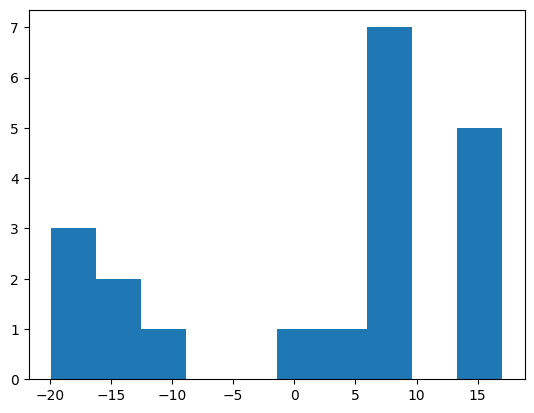

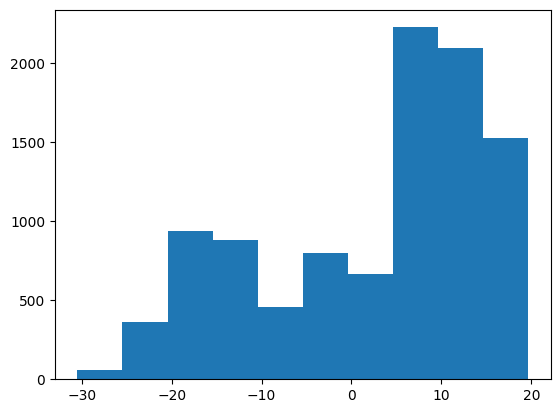

In [ ]:
# Visualize train/test data 

plt.hist(train_data, bins=10)
plt.show()
plt.hist(test_data, bins=10)
plt.show()

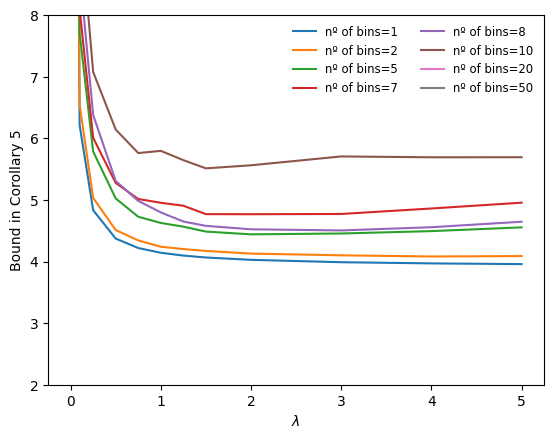

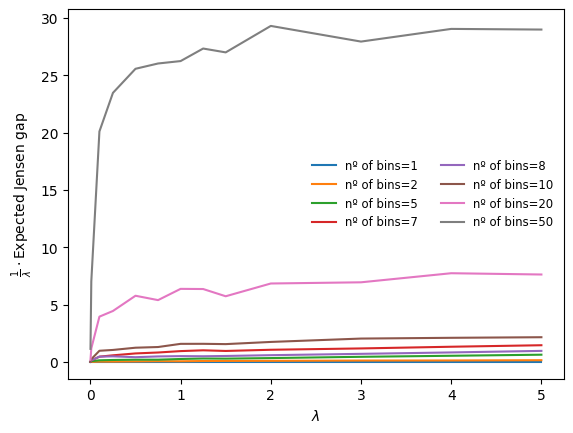

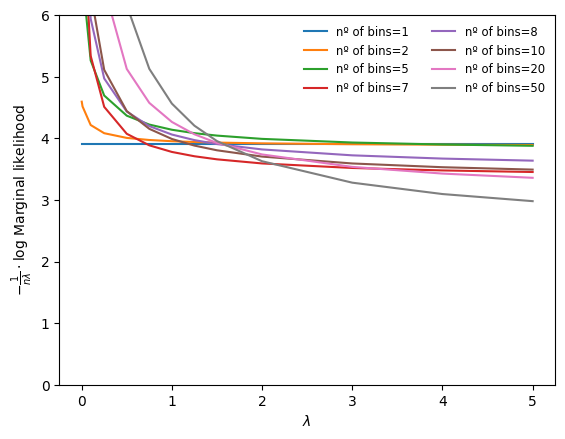

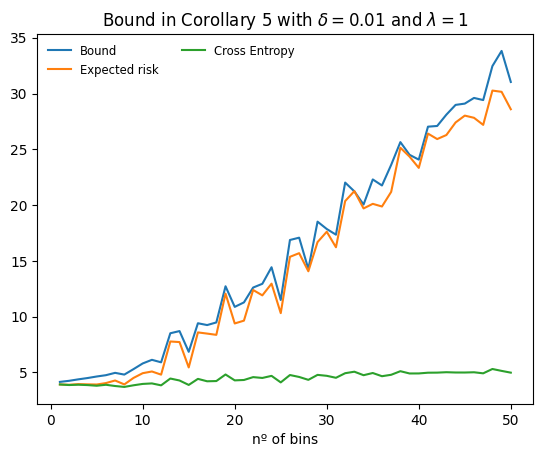

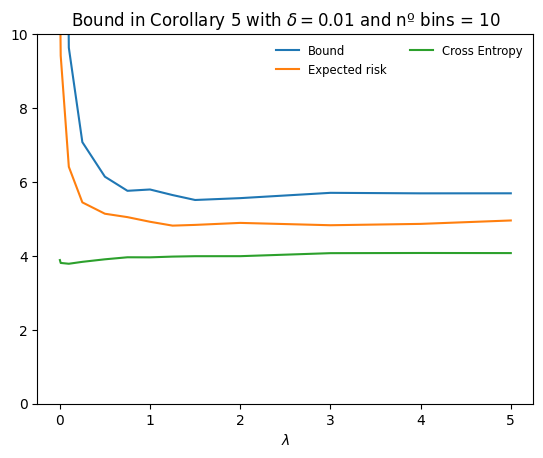

In [ ]:
# Different plots      
  
for i in [1, 2, 5, 7, 8, 10, 20, 50]:
    plt.plot(lambd,-1./(n_data*np.array(lambd))*log_marg[i-1, :, 0] + 1./np.array(lambd)*jensen_gap[i-1, :, 0] - 1./(n_data*np.array(lambd))*np.log(0.01), label='nº of bins={}'.format(i))
    plt.xlabel('$\lambda$')
    plt.ylabel('Bound in Corollary 5')
plt.legend(loc='best', ncol=2, frameon=False, fontsize='small')
plt.ylim(2, 8)
plt.show()
for i in [1, 2, 5, 7, 8, 10, 20, 50]:
    plt.plot(lambd, 1./np.array(lambd)*jensen_gap[i-1, :, 0], label='nº of bins={}'.format(i))
    plt.xlabel('$\lambda$')
    plt.ylabel(r'$\frac{1}{\lambda}\cdot$Expected Jensen gap')
plt.legend(loc='best', ncol=2, frameon=False, fontsize='small')
plt.show()

for i in [1, 2, 5, 7, 8, 10, 20, 50]:
    plt.plot(lambd, -1./(n_data*np.array(lambd))*log_marg[i-1, :, 0], label='nº of bins={}'.format(i))
    plt.xlabel('$\lambda$')
    plt.ylabel(r'$-\frac{1}{n\lambda}\cdot$log Marginal likelihood')
plt.legend(loc='best', ncol=2, frameon=False, fontsize='small')
plt.ylim(0, 6)
plt.show()


plt.plot(range(1, max_bins+1), -1./(n_data*lambd[6])*log_marg[:, 6, 0] + 1./lambd[6]*jensen_gap[:, 6, 0] - 1./(n_data*lambd[6])*np.log(0.01), label='Bound')
plt.plot(range(1, max_bins+1), expected_risk[:, 6, 0], label='Expected risk')
plt.plot(range(1, max_bins+1), cross_entropy[:, 6, 0], label='Cross Entropy')
plt.title('Bound in Corollary 5 with $\delta=0.01$ and $\lambda=1$')
plt.xlabel('nº of bins')
plt.legend(loc='best', ncol=2, frameon=False, fontsize='small')
plt.show()        
    
plt.ylim(0, 10)
plt.plot(lambd, -1./(n_data*np.array(lambd))*log_marg[9, :, 0] + 1./np.array(lambd)*jensen_gap[9, :, 0] - 1./(n_data*np.array(lambd))*np.log(0.01), label='Bound')
plt.plot(lambd, expected_risk[9, :, 0], label='Expected risk')
plt.plot(lambd, cross_entropy[9, :, 0], label='Cross Entropy')
plt.title('Bound in Corollary 5 with $\delta=0.01$ and nº bins = 10')
plt.xlabel('$\lambda$')
plt.legend(loc='best', ncol=2, frameon=False, fontsize='small')
plt.show()        

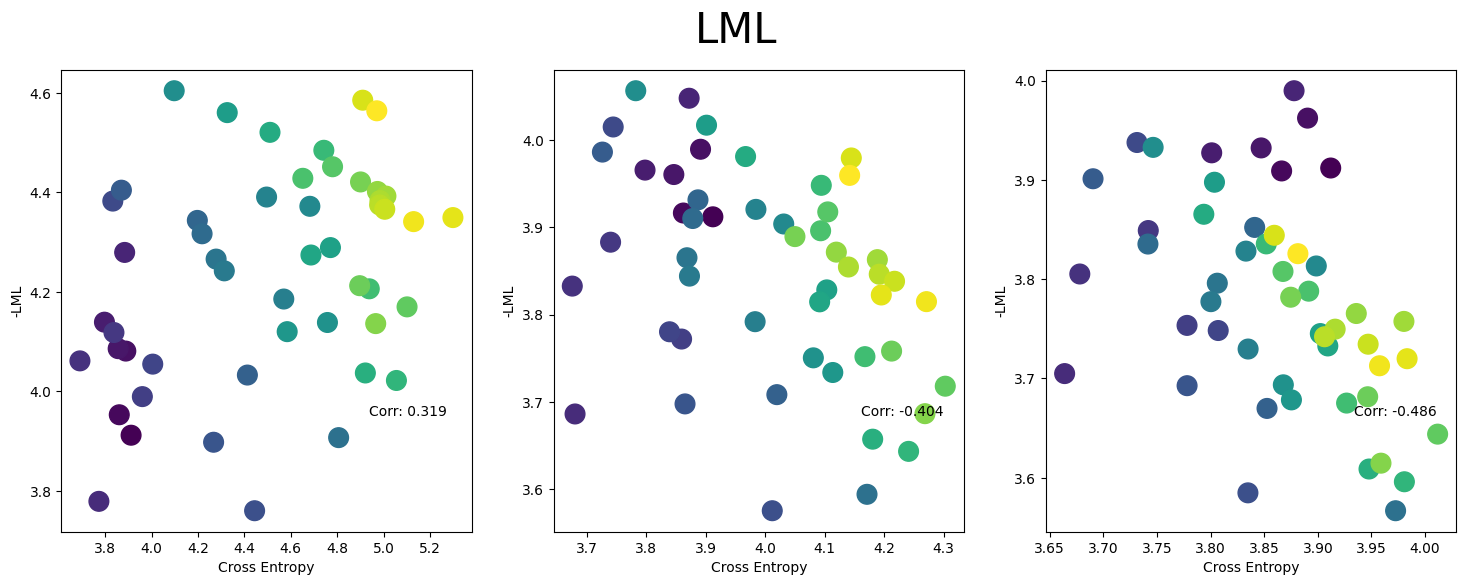

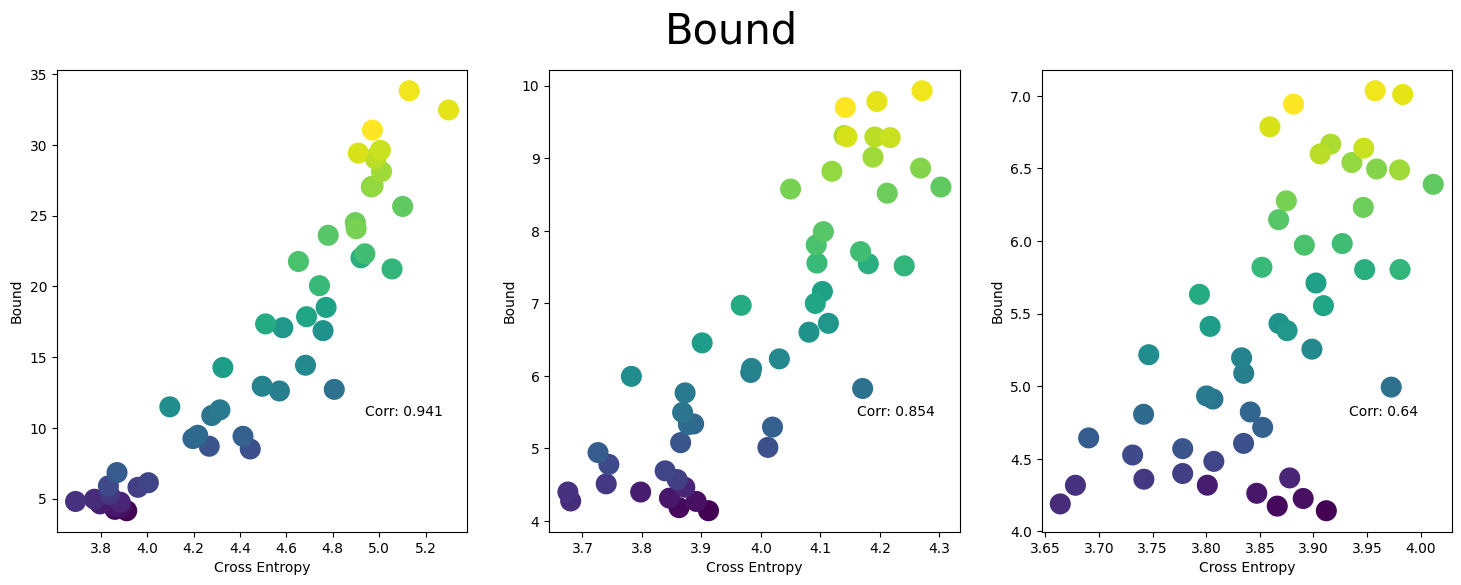

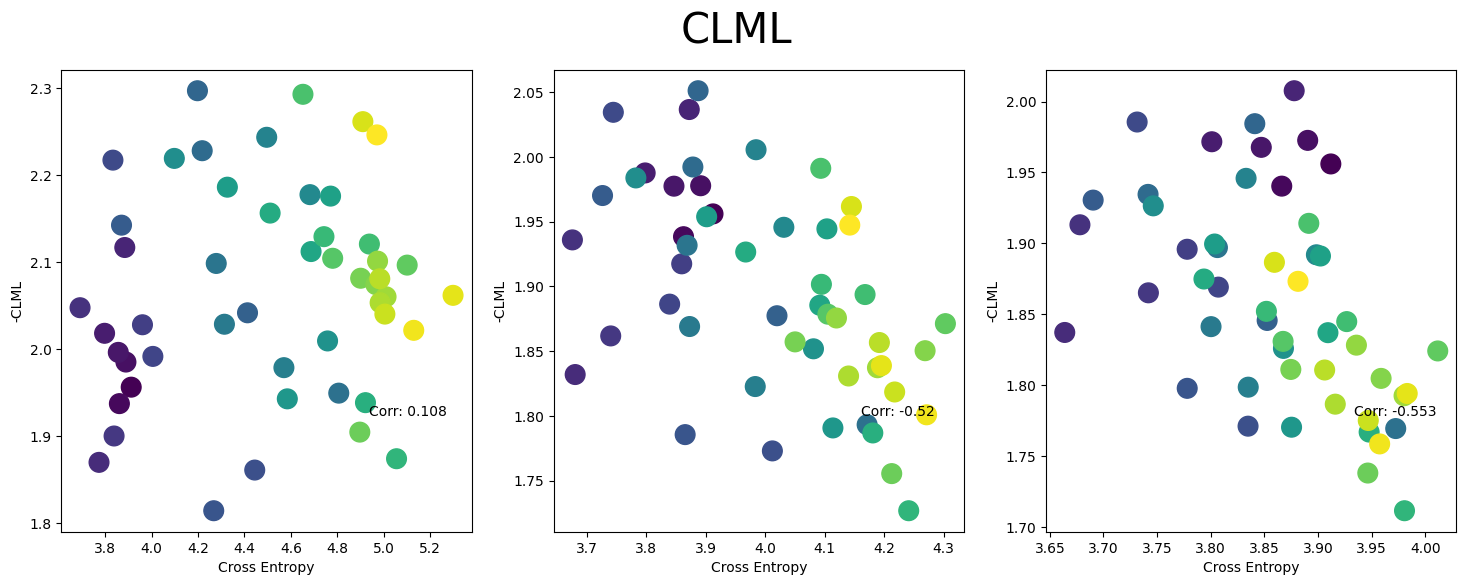

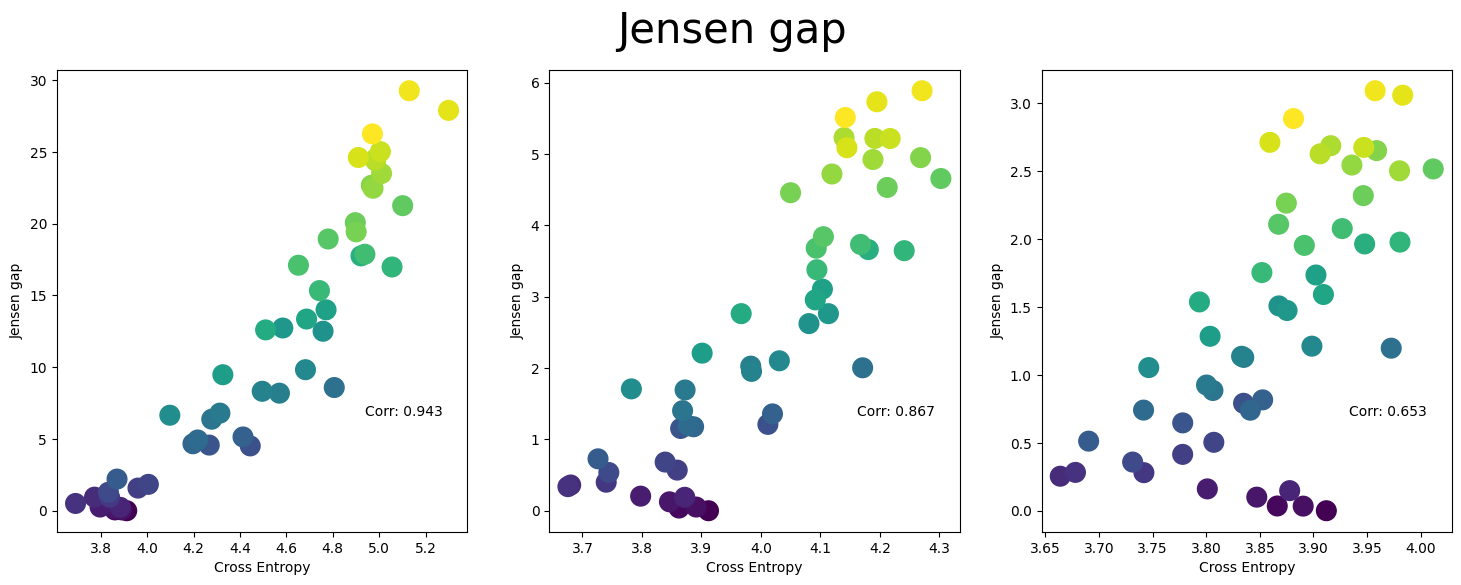

In [ ]:
# Correlation plots (\lambda = 1)

# Left to right: from more uniform to more concentrated priors


# -LML vs CE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):

    corr = spearmanr(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*log_marg[:, 6, i])[0]
    ax[i].scatter(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*log_marg[:, 6, i], c=np.arange(max_bins), s=200, cmap='viridis')
    ax[i].set(xlabel='Cross Entropy', ylabel='-LML')
    ax[i].annotate('Corr: {}'.format(np.round(corr, 3)), xy=(0.75, 0.25), xycoords='axes fraction')

fig.suptitle("LML", fontsize=30)
fig.show()

# Bound vs CE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):

    corr = spearmanr(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*log_marg[:, 6, i] + 1./lambd[6]*jensen_gap[:, 6, i] - 1./(n_data*lambd[6])*np.log(0.01))[0]
    ax[i].scatter(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*log_marg[:, 6, i] + 1./lambd[6]*jensen_gap[:, 6, i] - 1./(n_data*lambd[6])*np.log(0.01), c=np.arange(max_bins), s=200, cmap='viridis')
    ax[i].set(xlabel='Cross Entropy', ylabel='Bound')
    ax[i].annotate('Corr: {}'.format(np.round(corr, 3)), xy=(0.75, 0.25), xycoords='axes fraction')

fig.suptitle("Bound", fontsize=30)
fig.show()

# -CLML vs CE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):

    corr = spearmanr(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*conditional_log_marg[:, 6, i])[0]
    ax[i].scatter(cross_entropy[:, 6, i], -1./(n_data*lambd[6])*conditional_log_marg[:, 6, i], c=np.arange(max_bins), s=200, cmap='viridis')
    ax[i].set(xlabel='Cross Entropy', ylabel='-CLML')
    ax[i].annotate('Corr: {}'.format(np.round(corr, 3)), xy=(0.75, 0.25), xycoords='axes fraction')

fig.suptitle("CLML", fontsize=30)
fig.show()

# -LML vs CE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):

    corr = spearmanr(cross_entropy[:, 6, i], 1./(lambd[6])*jensen_gap[:, 6, i])[0]
    ax[i].scatter(cross_entropy[:, 6, i], 1./(lambd[6])*jensen_gap[:, 6, i], c=np.arange(max_bins), s=200, cmap='viridis')
    ax[i].set(xlabel='Cross Entropy', ylabel='Jensen gap')
    ax[i].annotate('Corr: {}'.format(np.round(corr, 3)), xy=(0.75, 0.25), xycoords='axes fraction')

fig.suptitle("Jensen gap", fontsize=30)
fig.show()


